In [2]:
# codigo de la url: https://colab.research.google.com/drive/1wWvtA5RC6-is6J8W86wzK52Knr3N1Xbm#scrollTo=VBXq-Wb_K1XR

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

2023-06-12 09:38:53.222975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 09:38:54.160403: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-12 09:38:54.160429: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-12 09:38:54.265930: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-12 09:38:57.219753: W tensorflow/stream_executor/platform/de

In [3]:
url = "/home/yass/code/yass2803/cryptoteller/data/BTCUSDT.csv"
df = pd.read_csv(url)
df.head()

,open_time,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
0,1577836800000,7195.24,7245.00,7175.46,7224.21,3646.232354,1577858399999,2.631450e+07,44901,1987.278850,1.434351e+07,0
1,1577858400000,7224.24,7237.73,7180.00,7197.20,4415.466238,1577879999999,3.182890e+07,51073,2173.642319,1.566963e+07,0
2,1577880000000,7197.20,7255.00,7196.15,7236.83,5443.680806,1577901599999,3.934948e+07,55857,3229.260535,2.334553e+07,0
3,1577901600000,7237.02,7246.72,7175.15,7200.85,3287.008767,1577923199999,2.372158e+07,42179,1556.773831,1.123912e+07,0
4,1577923200000,7200.77,7212.50,7116.70,7138.93,5561.311699,1577944799999,3.980317e+07,60466,2579.989270,1.846858e+07,0


In [4]:
# Change the time unit of the "open_time" and "close_time" columns
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms', origin='unix')
df = df.drop(columns=["close_time"])

In [5]:
df.shape

(4984, 11)

Text(0, 0.5, 'Close Price (USD)')

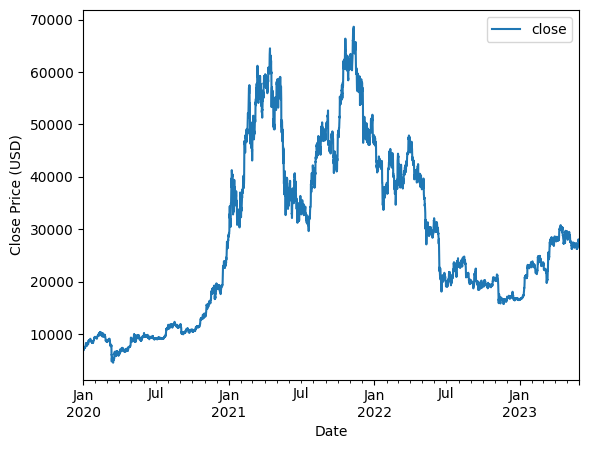

In [6]:
ax = df.plot(x='open_time', y='close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [8]:
scaler = MinMaxScaler()

close_price = df.close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [9]:
scaled_close.shape

(4984, 1)

In [10]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [12]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.80)

In [13]:
X_train.shape

(3907, 99, 1)

In [14]:
X_test.shape

(977, 99, 1)

# Model

In [17]:
from tensorflow.keras.layers import LSTM

DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))


# Training

In [19]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [21]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=3, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/3


55/55 [==============================] - 78s 1s/step - loss: 0.0054 - val_loss: 0.0163
Epoch 2/3
55/55 [==============================] - 92s 2s/step - loss: 0.0230 - val_loss: 0.0213
Epoch 3/3
55/55 [==============================] - 80s 1s/step - loss: 0.0229 - val_loss: 2.4542e-04


In [22]:
model.evaluate(X_test, y_test)

31/31 [==============================] - 9s 284ms/step - loss: 6.4120e-04


0.0006412002840079367

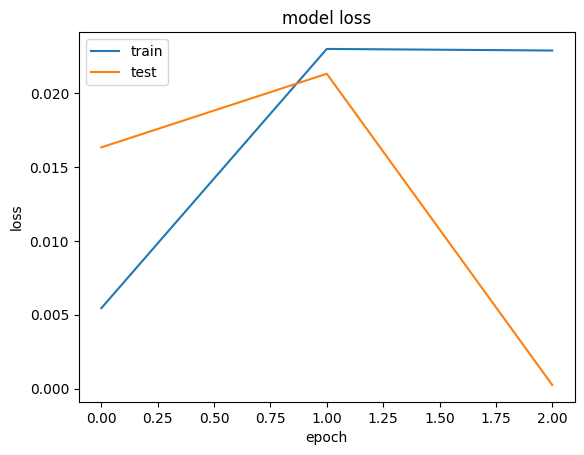

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

31/31 [==============================] - 19s 270ms/step


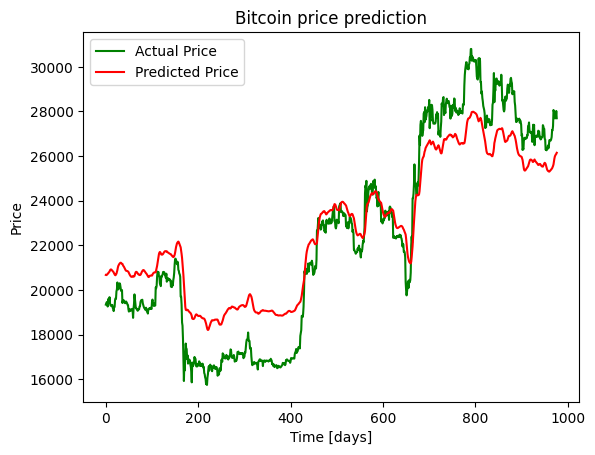

In [24]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();